In [1]:
# 영화 추천시스템 (Movie Recommendation System)
# 행렬 분해를 이용한 잠재 요인 협업 필터링 사용
# Keras Embedding layer를 적용한다.
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.layers import Flatten, Dot, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [22]:
# 학습 데이터를 읽어온다.
DATA_PATH = 'C:\\Users\\배진우\\Documents\\multiCampus_TA\\python_data\\ml-latest-small\\ml-latest-small\\'
movies = pd.read_csv(DATA_PATH + 'movies.csv')
ratings = pd.read_csv(DATA_PATH + 'ratings.csv')

df = pd.merge(ratings, movies, on='movieId')[['userId', 'movieId', 'rating', 'title']]


In [23]:
# userId와 movieId가 중간에 빈 값이 많으므로 순차적인 id를 다시 부여한다.
user_enc = LabelEncoder()
item_enc = LabelEncoder()

df['userId'] = user_enc.fit_transform(df['userId'])
df['movieId'] = item_enc.fit_transform(df['movieId'])
df['rating'] /= 5.0   # 0.5 ~ 5.0 --> 0.1 ~ 1.0으로 표준화.
df.head()

,userId,movieId,rating,title
0,0,0,0.8,Toy Story (1995)
1,4,0,0.8,Toy Story (1995)
2,6,0,0.9,Toy Story (1995)
3,14,0,0.5,Toy Story (1995)
4,16,0,0.9,Toy Story (1995)


In [24]:
# number of users and items
n_users = df['userId'].max() + 1
n_items = df['movieId'].max() + 1
n_factors = 50

In [25]:
# 학습 데이터와 시험 데이터로 분리
d_train, d_test = train_test_split(df, test_size = 0.1)

# 학습 데이터 세트를 생성한다.
x_user_train = np.array(d_train['userId']).reshape(-1, 1)
x_item_train = np.array(d_train['movieId']).reshape(-1, 1)
y_rating_train = np.array(d_train['rating']).reshape(-1, 1)

In [26]:
# 시험 데이터 세트를 생성한다.
x_user_test = np.array(d_test['userId']).reshape(-1, 1)
x_item_test = np.array(d_test['movieId']).reshape(-1, 1)
y_rating_test = np.array(d_test['rating']).reshape(-1, 1)

In [27]:
x_input_user = Input(batch_shape = (None, x_user_train.shape[1]))
x_input_item = Input(batch_shape = (None, x_item_train.shape[1]))

x_user_emb = Embedding(input_dim = n_users, output_dim = n_factors)(x_input_user)
x_user_emb = Dropout(rate=0.5)(x_user_emb)
x_user_emb = Flatten()(x_user_emb)

x_item_emb = Embedding(input_dim = n_items, output_dim = n_factors)(x_input_item)
x_item_emb = Dropout(rate=0.5)(x_item_emb)
x_item_emb = Flatten()(x_item_emb)

y_output = Dot(axes=1)([x_user_emb, x_item_emb])
# y_output = Activation('sigmoid')(y_output)
y_output = Activation('hard_sigmoid')(y_output)


model = Model([x_input_user, x_input_item], y_output)
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.001))
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 50)        30500       ['input_7[0][0]']                
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        486200      ['input_8[0][0]']                
                                                                                            

Epoch 1/30
89/89 [==============================] - 1s 6ms/step - loss: 0.0836 - val_loss: 0.0834
Epoch 2/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0834 - val_loss: 0.0833
Epoch 3/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0826 - val_loss: 0.0819
Epoch 4/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0789 - val_loss: 0.0755
Epoch 5/30
89/89 [==============================] - 0s 4ms/step - loss: 0.0685 - val_loss: 0.0620
Epoch 6/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0492
Epoch 7/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.0424
Epoch 8/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.0390
Epoch 9/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0371 - val_loss: 0.0370
Epoch 10/30
89/89 [==============================] - 0s 5ms/step - loss: 0.0352 - val_loss: 0.0357
Epoch 11/30
89/89 [

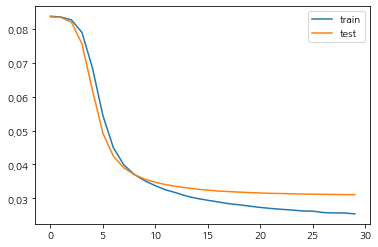

In [28]:
# 학습
hist = model.fit([x_user_train, x_item_train], y_rating_train, 
                 batch_size=1024, 
                 epochs = 30,
                 validation_data=([x_user_test, x_item_test], y_rating_test))

# loss 확인
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()


In [29]:
# 타겟 유저가 보지 않은 영화들에 대해 해당 유저가 부여할 rating을 추정한다.
user_id = user_enc.transform([9])[0]         # target user = 9
top_n = 20          # 추정 평점이 높은 상위 top_n개 추천

# target user가 본 movieId
seen_id = set(df[df['userId'] == user_id]['movieId'])

# target user가 보지 않은 movieId
unseen_id = list(set(df['movieId']) - seen_id)

In [30]:
# target user가 보지 않은 영화의 평점을 추정하기 위한 데이터 세트를 생성한다.
x_target_item = np.array(unseen_id, dtype=np.int32)
x_target_user = np.ones(shape = x_target_item.shape, dtype=np.int32) * user_id


In [31]:
# target user가 보지 않은 영화의 평점을 추정한다.
x_target_rating = model.predict([x_target_user, x_target_item])

# 추정 평점이 높은 순서로 정렬한다. 학습시 rating을 5로 나눠주었기 때문에, 다시 5를 곱해주었다.
x_target_df = pd.DataFrame({'userId': user_enc.inverse_transform(x_target_user), 
                            'movieId': item_enc.inverse_transform(x_target_item),
                            'rating': x_target_rating.reshape(-1) * 5})

x_target_df = x_target_df.sort_values(by = 'rating', ascending = False)[:top_n]
x_target_df[['userId', 'movieId']] = x_target_df[['userId', 'movieId']].astype('int64')
x_target_df.head()


,userId,movieId,rating
274,9,318,5.000000
597,9,750,4.991467
457,9,527,4.922862
654,9,858,4.898319
675,9,898,4.889508


In [32]:
# 추천 결과를 출력한다.
print('\n영화 추천 목록 : User = {}'.format(user_enc.inverse_transform([user_id])[0]))
print(" No {:40s} {:s}".format('Title', 'Expected rating'))
for i, (idx, row) in enumerate(x_target_df.iterrows()):
    title = movies[movies['movieId'] == row['movieId']]['title'].values[0]
    print("{:2d} : {:40s}     {:.4f}".format(i+1, title[:39], row['rating']))



영화 추천 목록 : User = 9
 No Title                                    Expected rating
 1 : Shawshank Redemption, The (1994)             5.0000
 2 : Dr. Strangelove or: How I Learned to St      4.9915
 3 : Schindler's List (1993)                      4.9229
 4 : Godfather, The (1972)                        4.8983
 5 : Philadelphia Story, The (1940)               4.8895
 6 : Pulp Fiction (1994)                          4.8513
 7 : Fight Club (1999)                            4.8138
 8 : Usual Suspects, The (1995)                   4.8112
 9 : Godfather: Part II, The (1974)               4.8048
10 : Patton (1970)                                4.7961
11 : Dark Knight, The (2008)                      4.7698
12 : Three Billboards Outside Ebbing, Missou      4.7697
13 : North by Northwest (1959)                    4.7456
14 : Trial, The (Procès, Le) (1962)               4.7394
15 : Monty Python and the Holy Grail (1975)       4.7305
16 : Bridge on the River Kwai, The (1957)         4.7302
17 : P

In [33]:
# 평가. MSE로 평가한다.
# 추천 결과에 대한 신뢰도로 활용할 수 있다.
# loss가 local min 지점에 빠질 수 있으므로 여러번 수행한 후 MSE가 작았을 때의 결과를 최종 결과로 선택한다.
pred = model.predict([x_user_test, x_item_test])

# MSE를 계산한다.
mse = mean_squared_error(pred, y_rating_test)
print('MSE =', mse.round(4))

from sklearn.metrics import r2_score
r2_score(y_rating_test, pred)

MSE = 0.0311


0.2734084210812041